# Imports

In [17]:
import tensorflow as tf
import numpy as np 
from skimage import io
from skimage.io import imread
import matplotlib.pyplot as plt
import os
#import cv2 as cv
import glob
import pathlib
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Loading data

Number of input patches: 270


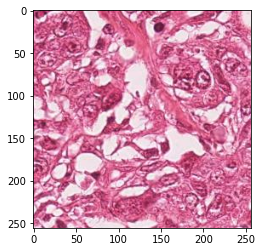

0
data_address ['E:/im_processing4/Input_data/Patch1/image_x0.jpeg', 'E:/im_processing4/Input_data/Patch1/image_x1.jpeg', 'E:/im_processing4/Input_data/Patch1/image_x10.jpeg', 'E:/im_processing4/Input_data/Patch1/image_x11.jpeg', 'E:/im_processing4/Input_data/Patch1/image_x12.jpeg', 'E:/im_processing4/Input_data/Patch1/image_x13.jpeg', 'E:/im_processing4/Input_data/Patch1/image_x14.jpeg', 'E:/im_processing4/Input_data/Patch1/image_x15.jpeg', 'E:/im_processing4/Input_data/Patch1/image_x16.jpeg', 'E:/im_processing4/Input_data/Patch1/image_x17.jpeg', 'E:/im_processing4/Input_data/Patch1/image_x18.jpeg', 'E:/im_processing4/Input_data/Patch1/image_x19.jpeg', 'E:/im_processing4/Input_data/Patch1/image_x2.jpeg', 'E:/im_processing4/Input_data/Patch1/image_x20.jpeg', 'E:/im_processing4/Input_data/Patch1/image_x21.jpeg', 'E:/im_processing4/Input_data/Patch1/image_x22.jpeg', 'E:/im_processing4/Input_data/Patch1/image_x23.jpeg', 'E:/im_processing4/Input_data/Patch1/image_x24.jpeg', 'E:/im_processi

(6, 256, 256, 1)
(6, 256, 256, 1)


In [18]:
DATADIR = "E:/im_processing4/Input_data/"
CATEGORIES = ["Patch1","Patch2","Patch3"]
filenames=[]
file_path=[]

for category in CATEGORIES:  
    clss_name, _ = os.path.splitext(category)
    if category == "Patch1":
        class_num = 0
    elif category == "Patch2":
        class_num = 0.5
    else:
        class_num = 0.9

    path = os.path.join(DATADIR,category) 
    
    for img in os.listdir(path): 
        name, _ = os.path.splitext(img)
        img_path = [path +"/"+name+".jpeg"]
        filenames=filenames+img_path
        file_path.append([img_path[0],class_num])
        
print("Number of input patches:",len(file_path))



data_address=[]
data_label=[]

for address,label in file_path:
    data_address.append(address)
    data_label.append(label)

#print(data_address)
#print(data_label)
f=imread(data_address[1])
plt.imshow(f)
plt.show()
print(data_label[1])
data_add = np.array(data_address)
data_lb = np.array(data_label)
print("data_address",data_address)
#print("data_label",data_lb.shape)

train_data, validation_data, train_label, validation_label = train_test_split(data_address, data_label, test_size=0.1)


def parse_function_T(train_data, train_label):
   
    image_string = tf.io.read_file(train_data)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    label=train_label
    
    return image, label


def parse_function_V(validation_data, validation_label):
   
    image_string = tf.io.read_file(validation_data) 
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    label=validation_label
    
    return image, label


def train_preprocess(image, label):
    
    image=image[...,tf.newaxis]
    image = image[:,:,2]
    
    return image, label


def show(image,label):
    plt.figure()
    plt.imshow(image)
    #plt.title(label.numpy().decode('utf-8'))
    plt.title(label)
    plt.axis('off')

#########Train data########

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_label))
train_dataset = train_dataset.shuffle(len(train_data))
train_dataset = train_dataset.map(parse_function_T)
train_dataset = train_dataset.map(train_preprocess)
train_dataset = train_dataset.batch(6)
#dataset = dataset.prefetch(1)

####Validation data#######

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_label))
validation_dataset = validation_dataset.shuffle(len(validation_data))
validation_dataset = validation_dataset.map(parse_function_V)
validation_dataset = validation_dataset.map(train_preprocess)
validation_dataset = validation_dataset.batch(6)
#dataset = dataset.prefetch(1)    

for image,label in validation_dataset.take(1):
    
    print(image.shape)
    #show(image,label.numpy())
     
for image,label in train_dataset.take(1):

    print(image.shape)
    #show(image,label.numpy())
    


# Training Network

In [19]:
######Traning Network #######

#train_data = np.asarray(train_data).astype("float32")
#train_data /= 255

model = Sequential()

#1st_convolutional_layer

model.add(Conv2D(64, (3, 3), input_shape=(256,256,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#2st_convolutional_layer

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#3st_convolutional_layer

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(1))

model.add(Activation('tanh'))

#model.compile(loss='binary_crossentropy',
              #optimizer='adam',metrics=['accuracy'])
model.compile(loss='mse',
              optimizer='adam')
model.summary()


filepath = "ModelWeights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor="loss")
history=model.fit(train_dataset, callbacks=[checkpoint],epochs=1,validation_data=validation_dataset)

#history=model.fit(train_data, train_label,batch_size=16,epochs=5,validation_split=0.1)

model.save('my_model_new.h5')  
del model  # deletes the existing model


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 254, 254, 64)      640       
_________________________________________________________________
activation_35 (Activation)   (None, 254, 254, 64)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 125, 125, 64)      36928     
_________________________________________________________________
activation_36 (Activation)   (None, 125, 125, 64)      0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 60, 60, 32)       